# Load Data

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [91]:
# import data
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

# EDA

0.7689676616915423

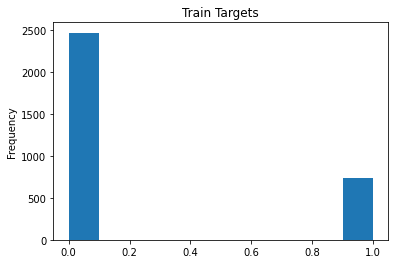

In [92]:
# see target distribution
train_df['Target'].plot.hist(title="Train Targets")
sum(train_df['Target'] == 0) / len(train_df)

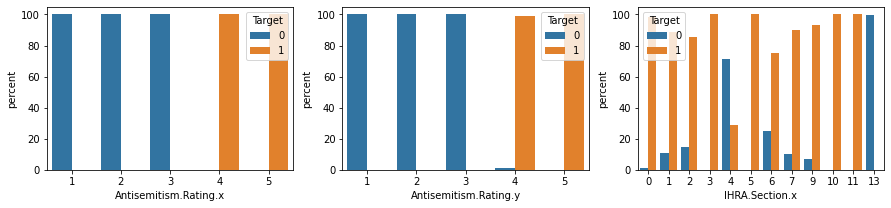

In [93]:
# look at some features
features = ['Antisemitism.Rating.x', 'Antisemitism.Rating.y', 'IHRA.Section.x']

app_train_df = train_df
fig = plt.figure(figsize=(15,3))
for idx, cat in enumerate(features):
  df = app_train_df.groupby(cat)['Target'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
  ax = fig.add_subplot(int("13{}".format(idx+1)))
  sns.barplot(x=cat,y='percent',hue='Target',data=df,ax=ax)

Notice how `Antisemitism.Rating.x` is more accurate than `Antisemitism.Rating.y`. This informs our decision to choose x instead of y

# Basic Model

We try it with the 2 most predictive features as a test. These turn out to predict the target with 100% accuracy

In [76]:
results = pd.DataFrame(columns=["ExpID", "Train Accuracy", "Test Accuracy", "Train Time(s)", "Test Time(s)", "Experiment description"])

In [77]:
cat_features = [
  "IHRA.Section.x", "Antisemitism.Rating.x"
]

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# custom layer to get columns we want from DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names].values
def pct(x):
    return round(100*x,1)

# pipeline
cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_features)),
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore")),
])

full_pipeline = Pipeline([
  ('preprocessing', cat_pipeline),
  ('linear', LogisticRegression())
])

In [94]:
from sklearn.metrics import accuracy_score
from time import time
train_all = train_df.sample(frac=0.8)
test_all = train_df.drop(index=train_all.index)
y_train = train_all[['Target']]
y_test = test_all[['Target']]

start = time()
full_pipeline.fit(train_all, y_train)
np.random.seed(42)
train_time = np.round(time() - start, 4)

preds = full_pipeline.predict(train_all)
train_score = accuracy_score(preds, y_train)

# Time and score test predictions
start = time()
preds = full_pipeline.predict(test_all)
test_score = accuracy_score(preds, y_test)
# roc = roc_auc_score(y_test, full_pipeline.predict_proba(X_test)[:, 1])
test_time = np.round(time() - start, 4)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
results.loc[0] = ["Baseline",pct(train_score), np.round(pct(test_score),3), 
                   train_time, test_time, "Untuned LogisticRegression"]
results

,ExpID,Train Accuracy,Test Accuracy,Train Time(s),Test Time(s),Experiment description
0,Baseline,100.0,100.0,0.066,0.0073,Untuned LogisticRegression


# Generate submission file

In [89]:
preds = full_pipeline.predict(test_df)
# submit_df = test[['SK_ID_CURR']]
submit_df = pd.DataFrame()
submit_df['Target'] = preds

submit_df.to_csv("submission.csv",index=False)

submit_df.head()

,Target
0,0
1,0
2,0
3,0
4,0
